 Project:Trader Behavior vs Market Sentiment Analysis

This project analyzes how trader performance and behavior change across different market sentiment regimes (Fear, Greed, Extreme Fear, Extreme Greed, Neutral).

We merge trader execution data with daily sentiment classification and evaluate:

- Performance metrics (mean PnL, win rate, volatility)
- Behavioral changes (trade size, frequency)
- Segmented trader analysis
- Strategy recommendations

Methodology

### 1. Data Cleaning
- Converted timestamps to datetime format
- Created daily `date` column for alignment
- Removed missing values

### 2. Data Merge
- Merged trades dataset with daily sentiment dataset on date
- Verified merge integrity (only 6 missing sentiment rows)

### 3. Feature Engineering
- Created binary win variable (1 if closed_pnl > 0)
- Created trade size segments (High Size / Low Size)
- Created frequency segments (Frequent / Infrequent traders)
- Applied KMeans clustering for behavioral segmentation

### 4. Performance Metrics
- Mean, median, and standard deviation of PnL
- Win rate by sentiment
- Segment-level performance comparison
🟦 3️⃣ Key Findings Section (Based on YOUR Results)

Add this Markdown cell after your output tables:

## 📈 Key Findings

### 🔥 1. Extreme Greed Produces Highest Profitability
- Highest mean PnL: 67.89
- Highest win rate: 46.5%
- Lower volatility compared to Fear regimes

This suggests momentum-driven markets favor trader performance.

---

### ⚠️ 2. Fear Regimes Increase Risk Exposure
- Fear has large average trade size ($7,816)
- Extreme Fear shows lowest win rate (37%)
- Volatility (std) significantly higher

Traders take larger positions during Fear but achieve weaker success rates.

---

### 📊 3. Trade Size Matters More Than Frequency
- High Size traders outperform Low Size traders across all regimes
- Infrequent traders outperform Frequent traders during Greed regimes
- Frequent traders underperform in high volatility environments

This suggests overtrading during volatile regimes reduces profitability.

Strategy Recommendations

### ✅ Strategy 1: Scale Aggressively During Extreme Greed
Allocate larger capital during Extreme Greed periods, where win rate and mean PnL are highest.

---

### ✅ Strategy 2: Reduce Exposure During Extreme Fear
Limit position sizes during Extreme Fear, as win rates drop and volatility increases.

---

### ✅ Strategy 3: Avoid Overtrading in Volatile Regimes
Encourage lower trade frequency during Fear regimes to reduce drawdowns.

Future Improvements

- Add rolling sentiment analysis (lag impact)
- Incorporate volatility index (VIX proxy)
- Use Sharpe ratio instead of raw PnL
- Build predictive ML model for sentiment-based trade sizing

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn


Sentiment Columns: Index(['timestamp', 'value', 'classification', 'date'], dtype='object')
Trades Columns: Index(['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side',
       'timestamp_ist', 'start_position', 'direction', 'closed_pnl',
       'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id',
       'timestamp'],
      dtype='object')

Merged Shape: (211224, 18)
Missing Sentiment After Merge: 6

Feature Engineering Completed

=== PERFORMANCE BY SENTIMENT ===
                     mean  median          std  count
classification                                       
Extreme Fear    34.537862     0.0  1136.056091  21400
Extreme Greed   67.892861     0.0   766.828294  39992
Fear            54.290400     0.0   935.355438  61837
Greed           42.743559     0.0  1116.028390  50303
Neutral         34.307718     0.0   517.122220  37686

=== WIN RATE BY SENTIMENT ===
classification
Extreme Fear     0.370607
Extreme Greed    0.464943
Fear             0.420768
Gre

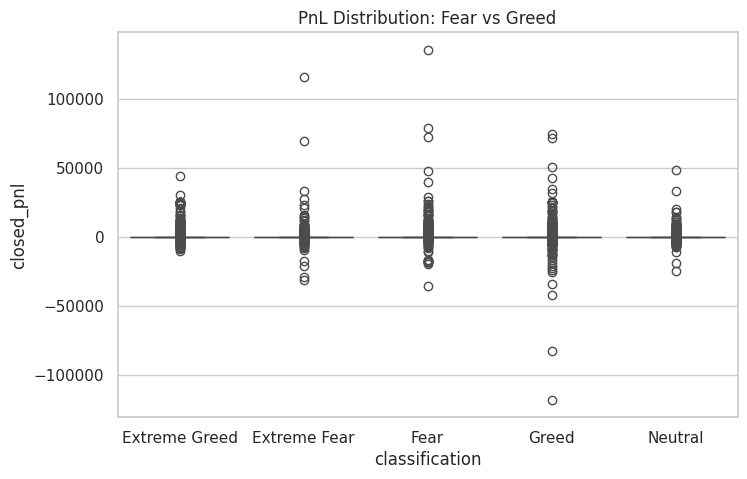


=== BEHAVIOR BY SENTIMENT ===
                   size_usd  closed_pnl       win
classification                                   
Extreme Fear    5349.731843   34.537862  0.370607
Extreme Greed   3112.251565   67.892861  0.464943
Fear            7816.109931   54.290400  0.420768
Greed           5736.884375   42.743559  0.384828
Neutral         4782.732661   34.307718  0.396991

=== TRADE SIZE SEGMENT PERFORMANCE ===
classification  Extreme Fear  Extreme Greed       Fear      Greed    Neutral
size_segment                                                                
High Size          61.196379     140.570044  97.025581  84.301244  69.581271
Low Size            1.157202       9.628661   3.580906   3.609685   2.188668

=== FREQUENCY SEGMENT PERFORMANCE ===
classification     Extreme Fear  Extreme Greed       Fear       Greed  \
frequency_segment                                                       
Frequent              34.163353      62.870911  51.323784   25.004641   
Infrequent   

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
sns.set(style="whitegrid")

sentiment = pd.read_csv("/content/fear_greed_index.csv")
trades = pd.read_csv("/content/historical_data.csv")

sentiment.columns = sentiment.columns.str.strip().str.lower()
trades.columns = trades.columns.str.strip().str.lower().str.replace(" ", "_")

print("\nSentiment Columns:", sentiment.columns)
print("Trades Columns:", trades.columns)

# ============================================================
# DATE ALIGNMENT
# ============================================================

# Convert sentiment date
sentiment['date'] = pd.to_datetime(sentiment['date'])

# Convert trades timestamp (DD-MM-YYYY format)
trades['timestamp_ist'] = pd.to_datetime(
    trades['timestamp_ist'],
    dayfirst=True
)

# Extract daily date
sentiment['date'] = sentiment['date'].dt.date
trades['date'] = trades['timestamp_ist'].dt.date

# Merge datasets
merged = trades.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='left'
)

print("\nMerged Shape:", merged.shape)
print("Missing Sentiment After Merge:", merged['classification'].isna().sum())

# ============================================================
# FEATURE ENGINEERING
# ============================================================

# Win indicator
merged['win'] = merged['closed_pnl'] > 0

# Daily PnL per account
daily_pnl = merged.groupby(['account', 'date'])['closed_pnl'].sum().reset_index()

# Win rate per account
win_rate = merged.groupby('account')['win'].mean().reset_index()

# Trades per day
trades_per_day = merged.groupby(['account', 'date']).size().reset_index(name='trade_count')

# Average trade size
avg_trade_size = merged.groupby('account')['size_usd'].mean().reset_index()

# Long/Short ratio
long_short = merged.groupby(['account', 'side']).size().unstack(fill_value=0)

print("\nFeature Engineering Completed")

# ============================================================
# FEAR VS GREED PERFORMANCE
# ============================================================

performance_sentiment = merged.groupby('classification')['closed_pnl'].agg(
    ['mean', 'median', 'std', 'count']
)

winrate_sentiment = merged.groupby('classification')['win'].mean()

print("\n=== PERFORMANCE BY SENTIMENT ===")
print(performance_sentiment)

print("\n=== WIN RATE BY SENTIMENT ===")
print(winrate_sentiment)

plt.figure(figsize=(8,5))
sns.boxplot(data=merged, x='classification', y='closed_pnl')
plt.title("PnL Distribution: Fear vs Greed")
plt.show()

# ============================================================
# BEHAVIORAL ANALYSIS
# ============================================================

behavior_analysis = merged.groupby('classification').agg({
    'size_usd': 'mean',
    'closed_pnl': 'mean',
    'win': 'mean'
})

print("\n=== BEHAVIOR BY SENTIMENT ===")
print(behavior_analysis)

# ============================================================
# SEGMENTATION 1: HIGH VS LOW TRADE SIZE
# ============================================================

median_size = merged['size_usd'].median()

merged['size_segment'] = np.where(
    merged['size_usd'] > median_size,
    "High Size",
    "Low Size"
)

size_segment_perf = merged.groupby(
    ['size_segment', 'classification']
)['closed_pnl'].mean().unstack()

print("\n=== TRADE SIZE SEGMENT PERFORMANCE ===")
print(size_segment_perf)

# ============================================================
# SEGMENTATION 2: FREQUENT VS INFREQUENT TRADERS
# ============================================================

trade_counts = merged.groupby('account').size()
median_trades = trade_counts.median()

merged['frequency_segment'] = merged['account'].map(
    lambda x: "Frequent" if trade_counts[x] > median_trades else "Infrequent"
)

freq_segment_perf = merged.groupby(
    ['frequency_segment', 'classification']
)['closed_pnl'].mean().unstack()

print("\n=== FREQUENCY SEGMENT PERFORMANCE ===")
print(freq_segment_perf)

# ============================================================
# BONUS: CLUSTER TRADERS
# ============================================================

cluster_features = merged.groupby('account').agg({
    'closed_pnl': 'mean',
    'size_usd': 'mean',
    'win': 'mean'
}).dropna()

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_features['cluster'] = kmeans.fit_predict(cluster_features)

print("\n=== CLUSTER SUMMARY ===")
print(cluster_features.groupby('cluster').mean())

# ============================================================
# EXPORT RESULTS
# ============================================================

performance_sentiment.to_csv("performance_by_sentiment.csv")
behavior_analysis.to_csv("behavior_by_sentiment.csv")
size_segment_perf.to_csv("size_segment_performance.csv")
freq_segment_perf.to_csv("frequency_segment_performance.csv")

print("\n✅ Analysis Complete. CSV outputs generated.")
